In [41]:
# uncomment the following line to install the required packages
"""
pip install pandas numpy matplotlib hdbscan umap-learn
"""

'\npip install pandas numpy matplotlib hdbscan umap-learn\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json
import sqlite3

In [2]:
conn = sqlite3.connect("../data/simonwillisonblog.db")


In [3]:
def run_query(query):
    return pd.read_sql_query(query, conn)


In [4]:
# select all of the blog entries in the same order as the blog_entry_embeddings table
marks = run_query("SELECT id,link_url,link_title,commentary,created FROM blog_blogmark order by id ASC")

In [6]:
marks.head()

,id,link_url,link_title,commentary,created
0,1,http://www.perl.com/pub/a/2003/11/21/slurp.html,Perl Slurp-Eaze,I once saw an expensive CMS self destruct afte...,2003-11-23T23:51:23+00:00
1,2,http://funformkit.sourceforge.net/FunFormKit/D...,FunFormKit Quick Start,You wouldn't believe how similar this is to a ...,2003-11-23T23:53:10+00:00
2,3,http://nltk.sourceforge.net/,Python Natural Language Toolkit,Yet another reason Python at University is a g...,2003-11-23T23:54:54+00:00
3,4,http://www.pfdubois.com/numpy/,Numerical Python,Some day I really ought to get this installed ...,2003-11-23T23:55:55+00:00
4,5,http://holton.ltc.vanderbilt.edu/wiki/UserMode...,UserModeLinux - Educational Technology Wiki,Includes a list of cheap UML hosts - $15/month...,2003-11-23T23:56:47+00:00


In [13]:
# combine link_url, link_title and commentary into a single text field
marks["text"] = marks["link_title"] + ": " + marks["link_url"] + "\n" + marks["commentary"]

In [14]:
marks.head()

,id,link_url,link_title,commentary,created,text
0,1,http://www.perl.com/pub/a/2003/11/21/slurp.html,Perl Slurp-Eaze,I once saw an expensive CMS self destruct afte...,2003-11-23T23:51:23+00:00,Perl Slurp-Eaze: http://www.perl.com/pub/a/200...
1,2,http://funformkit.sourceforge.net/FunFormKit/D...,FunFormKit Quick Start,You wouldn't believe how similar this is to a ...,2003-11-23T23:53:10+00:00,FunFormKit Quick Start: http://funformkit.sour...
2,3,http://nltk.sourceforge.net/,Python Natural Language Toolkit,Yet another reason Python at University is a g...,2003-11-23T23:54:54+00:00,Python Natural Language Toolkit: http://nltk.s...
3,4,http://www.pfdubois.com/numpy/,Numerical Python,Some day I really ought to get this installed ...,2003-11-23T23:55:55+00:00,Numerical Python: http://www.pfdubois.com/nump...
4,5,http://holton.ltc.vanderbilt.edu/wiki/UserMode...,UserModeLinux - Educational Technology Wiki,Includes a list of cheap UML hosts - $15/month...,2003-11-23T23:56:47+00:00,UserModeLinux - Educational Technology Wiki: h...


In [17]:
# write the id and text columns to a csv file
marks[["id", "text"]].to_csv("../data/simonw-blogmarks.csv", index=False)

In [18]:
with open('../data/simonw-blogmarks-embeddings.json', 'r') as f:
    metadata = json.load(f)

In [23]:
with open('../data/simonw-blogmarks-embeddings.bin', 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)

In [28]:
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [29]:
embeddings.shape

(6578, 1536)

In [60]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.05,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True
)

In [101]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_neighbors=25, random_state=42, verbose=True)
Tue Apr 18 16:17:24 2023 Construct fuzzy simplicial set
Tue Apr 18 16:17:24 2023 Finding Nearest Neighbors
Tue Apr 18 16:17:24 2023 Building RP forest with 9 trees
Tue Apr 18 16:17:24 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Tue Apr 18 16:17:24 2023 Finished Nearest Neighbor Search
Tue Apr 18 16:17:24 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Apr 18 16:17:32 2023 Finished embedding


In [102]:
umap_embeddings.shape

(6578, 2)

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_2082/1776845616.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=3, cmap='Spectral')


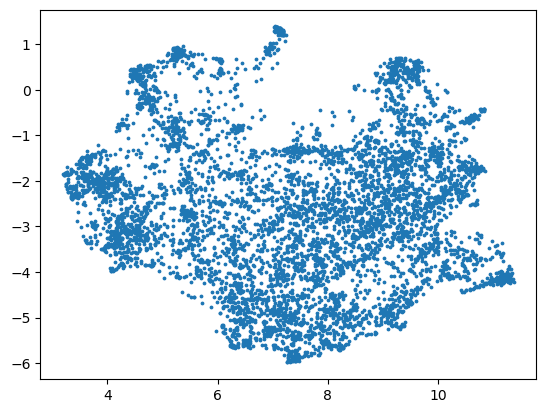

In [104]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=3, cmap='Spectral')
plt.show()

In [64]:
#write embedding to csv file with header x,y
np.savetxt("../data/simonw-blogmarks-umap.csv", embedding, delimiter=",", header="x,y", comments='')

In [84]:
# Create an HDBSCAN instance with custom parameters
# cluster based on UMAP
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric='euclidean')
clusterer.fit(embedding)
# cluster based on high dimensional data (embeddings)
# from sklearn.metrics import pairwise_distances
# cosine_similarity = pairwise_distances(embeddings, metric='cosine')
# cosine_distance = 1 - cosine_similarity
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric='precomputed')
# clusterer.fit_predict(cosine_distance)


HDBSCAN(min_cluster_size=10, min_samples=10)

In [94]:
cluster_labels = clusterer.labels_

In [96]:
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92])

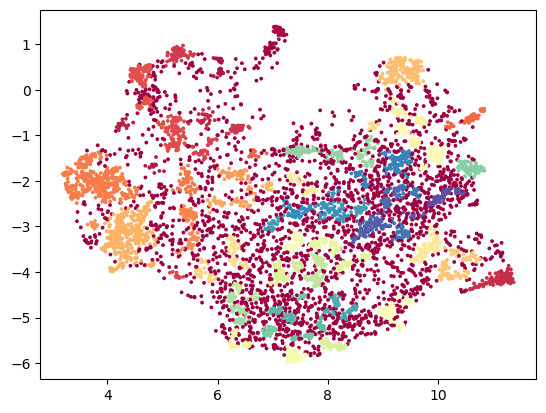

In [98]:
# plot embedding with cluster labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, s=3, cmap='Spectral')

In [100]:
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)
non_noise_labels = unique_labels[unique_labels != -1]
centroids = [embedding[cluster_labels == label].mean(axis=0) for label in non_noise_labels]

In [140]:
from scipy.spatial.distance import cdist

In [141]:
# Assign noise points to the closest cluster centroid
noise_points = umap_embeddings[cluster_labels == -1]
closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)


In [142]:
# Update cluster_labels with the new assignments for noise points
noise_indices = np.where(cluster_labels == -1)[0]
new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
cluster_labels[noise_indices] = new_assignments

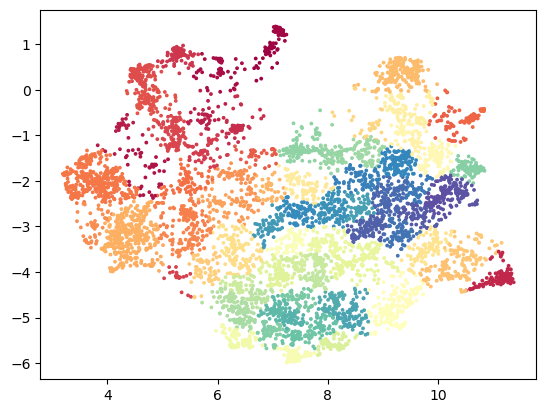

In [144]:
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')

In [145]:
# write clusterer.labels_ to a csv file
np.savetxt("../data/simonw-blogmarks-hdbscan.csv", clusterer.labels_, delimiter=",", header="cluster", comments="")

In [151]:
# select all of the blog entries in the same order as the blog_entry_embeddings table
data = marks[["id", "text"]].copy()

In [152]:
data.shape

(6578, 2)

In [153]:
# add the cluster labels to the dataframe
data['cluster'] = clusterer.labels_

In [154]:
# add x and y as columns to the dataframe from the embedding
data['x'] = embedding[:, 0]
data['y'] = embedding[:, 1]

In [155]:
data.head()

,id,text,cluster,x,y
0,1,Perl Slurp-Eaze: http://www.perl.com/pub/a/200...,22,5.625864,-3.309059
1,2,FunFormKit Quick Start: http://funformkit.sour...,56,6.891455,-3.789135
2,3,Python Natural Language Toolkit: http://nltk.s...,28,4.569206,-3.375009
3,4,Numerical Python: http://www.pfdubois.com/nump...,28,4.527949,-3.303950
4,5,UserModeLinux - Educational Technology Wiki: h...,15,6.860212,-1.719312


In [156]:
# write the dataframe to a csv file
data.to_csv("../data/simonw-blogmarks-processed.csv", index=False)

In [157]:
# group by cluster and concat the titles
cluster_extract = data.groupby('cluster')['text'].apply(lambda x: '\n*'.join(x)).reset_index()

In [158]:
# rename the title column of cluster_titles to summary
cluster_extract.rename(columns={'text': 'extract'}, inplace=True)

In [159]:
# save the cluster titles to a csv file
cluster_extract.to_csv('../data/simonw-blogmarks-cluster-extract.csv', index=False)